In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import psycopg2 as pg
import pandas as pd
import sys
import os
sys.path.append("C:/Users/Jeppe/Documents/GitHub/BiksStonks/Forcasting_Models")
import utils.preprocess as preprocess
import utils.DatasetAccess as DatAccess

C:\Users\Jeppe\Stonk\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# code by Tae Hwan Jung @graykode
# Reference : https://github.com/hunkim/PyTorchZeroToAll/blob/master/14_2_seq2seq_att.py


# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
class DatabaseConnection:
    def __init__(self):
        self.conn = self.connect()
    def connect(self):
        try:
            self.conn = pg.connect(
                "dbname='stonksdb' user='postgres' host='localhost' password='admin'")
            print("Connection made succ")
            return self.conn
        except:
            print("I am unable to connect to the database")
            return None
    def close(self):
        self.conn.close()
    
    def GetConnector(self):
        return self.conn
    ### send query to database
    def query(self, query):
        cur = self.conn.cursor()
        cur.execute(query)
        return cur.fetchall()

class DatasetAccess:
    def __init__(self):
        self.conn = DatabaseConnection()

    def getNcompanies(self, N):
        AllCompanies = self.conn.query("SELECT * FROM dataset limit "+ str(N)+"")
        return AllCompanies

    def GetNumberOfCompanies(self):
        return self.conn.query("SELECT count(*) FROM dataset")

    def getStockFromSymbol(self, StockSymbol, column = '*'):
        company = self.conn.query("SELECT * FROM dataset WHERE symbol = '" + StockSymbol + "'")
        self.getStockFromCompany(company, column)
        return company

    def getStockFromCompany(self, companies, column = '*'):
        result = []
        for company in companies:
            result.append(self.conn.query("SELECT "+self.convertListToString(column)+" FROM stock WHERE identifier = '" + str(company[0]) + "'"))
        return result
    def convertListToString(self, column):
        if type(column) != list:
            return column
        result = ''
        for item in column:
            result += item + ', '
        return result[:-2]
    def getStockDFFromCompany(self, companies, column = '*'):
        result = []
        print(companies)
        for company in companies:
            result.append(pd.read_sql("SELECT "+self.convertListToString(column)+" FROM stock WHERE identifier = '" + str(company[0]) + "' order by time asc", self.conn.GetConnector()))
        return result
    def GetAllStocksAsDF(self):
        PandaStock = pd.read_sql('SELECT * FROM stock', self.conn.GetConnector())
        print(PandaStock)
    
def GetDF():
    dbaccess = DatasetAccess()
    vestas = pd.read_sql("select * from stock where identifier = 15611 ", dbaccess.conn.GetConnector())
    return vestas
    
def GetNumberOfCompanies():
    dbAccess = DatasetAccess()
    return dbAccess.GetNumberOfCompanies()

def GetSingleStockDF():
    dbAccess = DatasetAccess()
    comp = dbAccess.getNcompanies(2)
    return dbAccess.getStockDFFromCompany(comp, column="close")

def GetStocks(n):
    dbAccess = DatasetAccess()
    comp = dbAccess.getNcompanies(n)
    return dbAccess.getStockDFFromCompany(comp, column="close")

def GetStocksHourly(n):
    dbAccess = DatasetAccess()
    comps = dbAccess.getNcompanies(n)
    result = []
    for comp in comps:
        result.append(DatAccess.get_data_for_datasetid(str(comp[0]),dbAccess.conn.GetConnector(),"h")["close"])
    return result
# test = GetStocksHourly(10)

In [4]:
def make_batch():
    replica_input = train
    replica_input = [np.array(replica_input)]
    replica_Input = [n for n in replica_input[0]]
    print("____________-")
    replica_output = target
    replica_output = [np.array(replica_output)]
    replica_Output = [n for n in replica_output[0]]
    print("____________-")
    replica_target = target
    replica_target = [np.array(replica_target)]
    replica_Target = [n for n in replica_target[0]]
    return torch.FloatTensor(replica_Input), torch.FloatTensor(replica_Output), torch.FloatTensor(replica_Target)

In [5]:
class Attention(nn.Module):
    def __init__(self,Output_size,n_class,hidden_size):
        super(Attention, self).__init__()
        self.Output_size = Output_size
        self.n_hidden = hidden_size
        self.n_class = n_class
        self.enc_cell = nn.RNN(input_size=self.n_class, hidden_size=self.n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=self.n_class, hidden_size=self.n_hidden, dropout=0.5)
        self.attn = nn.Linear(self.n_hidden, self.n_hidden)
        self.pls = None
    def forward(self, enc_inputs, hidden, dec_inputs):
        # print("dec_inputs1", dec_inputs.shape)
        # dec_inputs1 torch.Size([32, 50, 1]) [batchsize, points, num of vars]
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)
        trained_attn = []
        hidden = enc_hidden
        dec_outputs, hidden = self.dec_cell(dec_inputs, hidden)
        enc_outputs = enc_outputs.transpose(0, 1)
        dec_outputs = dec_outputs.transpose(0, 1)
        enc_outputs = self.attn(enc_outputs)
        attention_weights = torch.nn.functional.softmax(torch.bmm(dec_outputs, enc_outputs.transpose(1,2)), dim=-1)
        context = torch.bmm(attention_weights, enc_outputs)
        combine = torch.cat((dec_outputs, context), 2)
        combine = combine.view(combine.shape[0], self.Output_size, -1)
        if self.pls == None:
            self.pls = nn.Linear(combine.shape[2], n_class)
        return self.pls(combine), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
    
        return score #torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

In [6]:
from itertools import islice

def window1(seq, n=2):
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

def getBigData(n_company):
    stocks = []
    NumberOfCompanies = GetNumberOfCompanies()[0][0]
    print("NumberOfCompanies", NumberOfCompanies)
    if NumberOfCompanies >= n_company:
        for stock in GetStocksHourly(n_company):
            stocks.append(np.array(stock[:5000]).flatten())
    
        WindowedStocks = []
        for stock in stocks:
            WindowedStocks.append(window1(stock, PointSize))

        result = []
        for window in WindowedStocks:
            for i in window:
                result.append(i)
    else:
        result = []
        print("There are only {NumberOfCompanies} not {n_company} as requested".format(NumberOfCompanies=NumberOfCompanies, n_company=n_company))

    return result

def getData():
    a = np.array(GetSingleStockDF()[1][:10000]).flatten()
    b = np.array(GetSingleStockDF()[0][:10000]).flatten()

    bop = [a,b]
    result = []
    for i in bop:
        result.append(window1(i,PointSize))
    actual = []
    for it in result:
        for window in it:
            actual.append(window)
    return actual
# bd = getBigData()


In [10]:
closingoriginData = np.array(getBigData(10))
closingData = (closingoriginData - closingoriginData.mean()) / closingoriginData.std()
print("closingData", closingData.shape)
openData = np.array(getBigData(10))
openData = (openData - openData.mean()) / openData.std()

Connection made succ
NumberOfCompanies 10
Connection made succ


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 conne

closingData (36931, 200)
Connection made succ
NumberOfCompanies 10
Connection made succ


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 conne

In [12]:
closingoriginData, closingoriginData.shape

(array([[4832. , 4866. , 4956. , ..., 6295. , 6320. , 6285. ],
        [4866. , 4956. , 4924. , ..., 6320. , 6285. , 6165. ],
        [4956. , 4924. , 4934. , ..., 6285. , 6165. , 6130. ],
        ...,
        [ 670.4,  681.6,  677.6, ...,  779.4,  775.2,  777. ],
        [ 681.6,  677.6,  682.6, ...,  775.2,  777. ,  780.8],
        [ 677.6,  682.6,  685.8, ...,  777. ,  780.8,  793.4]]),
 (36931, 200))

In [ ]:
closing = closingData.reshape(closingData.shape[0], closingData.shape[1],1)
opens = openData.reshape(openData.shape[0], openData.shape[1],1)
data = torch.concat((torch.FloatTensor(closing), torch.FloatTensor(opens)), 2)
Output_size = 10
train = np.array([np.array(d[:PointSize-Output_size]) for d in data])
target = np.array([np.array(d[PointSize-Output_size:]) for d in data])

In [9]:
if __name__ == '__main__':
    n_step = 90 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell
    n_class = 2
    PointSize = 200
    Epoch = 32
    batch_size = 32
    num_layers = 1
    trainer = torch.from_numpy(train).float()
    targeter = torch.from_numpy(target).float()

    dataset = torch.utils.data.TensorDataset(trainer,targeter)
    dtloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=True, drop_last=True)

    hidden = torch.zeros(num_layers, batch_size, n_hidden)
    model = Attention(Output_size,n_class,n_hidden)
    criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Train
    model.train()
    for epoch in range(Epoch):
        for x, y in dtloader:
            optimizer.zero_grad()
            if(n_class != 1):
                x = x.squeeze(-1)
                y = y.squeeze(-1)
            else:
                x = x.unsqueeze(-1)
                y = y.unsqueeze(-1)
            output, _ = model(x, hidden, x)
            loss = criterion(output, y.squeeze(0))
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 5 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'MSE =', '{:.6f}'.format(loss))

NameError: name 'train' is not defined

In [ ]:
input_batch.squeeze(-1).shape, output_batch.shape, target_batch.shape
stuff = input_batch.squeeze(-1)
idx = 900
#print("stuff", stuff[idx])
groundTruth = [float(x[0]) for x in stuff[idx]]
print("groundTruth", groundTruth)

groundTruth [0.9341663122177124, 0.9374664425849915, 0.9457166790962219, 0.9490167498588562, 0.9745924472808838, 0.960567057132721, 0.9721173644065857, 0.963042140007019, 0.9754174947738647, 0.9811926484107971, 0.9853177666664124, 0.978717565536499, 0.9737673997879028, 0.9721173644065857, 0.9688172936439514, 0.9679922461509705, 0.9745924472808838, 0.9861427545547485, 0.9886178374290466, 0.9993431568145752, 0.9795425534248352, 0.9836676716804504, 0.9844927191734314, 0.9622170925140381, 0.9399414658546448, 0.9316912889480591, 0.9300411939620972, 0.9143657684326172, 0.94406658411026, 0.9341663122177124, 0.9267411231994629, 0.9308662414550781, 0.9366413950920105, 0.9366413950920105, 0.9374664425849915, 0.9341663122177124, 0.913540780544281, 0.929216206073761, 0.9325162768363953, 0.9184908866882324, 0.9168408513069153, 0.9201409220695496, 0.9193159341812134, 0.9094156622886658, 0.9193159341812134, 0.9234410524368286, 0.9267411231994629, 0.9242660403251648, 0.9201409220695496, 0.916840851306

In [ ]:
idx = 900

# plot graph
y_ground = np.concatenate((input_batch[idx].reshape(-1), target_batch[idx].reshape(-1)), 0)
model.eval()
hidden = torch.zeros(num_layers, 1, n_hidden)
y_pred = model(input_batch[idx].unsqueeze(0), hidden, input_batch[idx].unsqueeze(0))[0].detach().numpy().reshape(-1) 
y_pred = np.concatenate((input_batch[idx].reshape(-1), y_pred), 0)

# plot graph
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(y_pred, label='Prediction', c="orange")
ax.plot(y_ground, label='Ground Truth')
# plt add v line at 50 
ax.axvline(PointSize-Output_size, color='green', linestyle='--')
ax.legend()
plt.show()

TypeError: only integer tensors of a single element can be converted to an index

Connection made succ
[(6043, 'Stock', 'DKK', 'A.P. Møller - Mærsk A A/S', 'CSE', '895', 'DK', '6043', 'Instrument', 'MAERSKa:xcse', 'UNKNOWN'), (6041, 'Stock', 'DKK', 'A.P. Møller - Mærsk B A/S', 'CSE', '895', 'DK', '6041', 'Instrument', 'MAERSKb:xcse', 'UNKNOWN')]


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


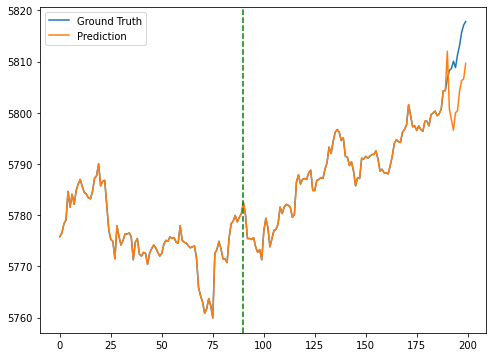

In [ ]:
closingData = GetSingleStockDF()[1][:1000].values
# re scale data
y_ground = (y_ground * closingData.std()) + closingData.mean()
y_pred = (y_pred * closingData.std()) + closingData.mean()
# plot graph
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(y_ground, label='Ground Truth')
ax.plot(y_pred, label='Prediction')
# plt add v line at 50
ax.axvline(90, color='green', linestyle='--')
ax.legend()
plt.show()

In [ ]:
closingData.mean(), closingData.var()


(5571.566, 47794.48764400001)

In [ ]:
# use pandas rolling windows to split up the data
data = GetDF()
data.rolling(window=50).mean()
data

Connection made succ


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\AppData\Local\Temp\ipykernel_26460\327577449.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['time'], dtype='object')
  data.rolling(window=50).mean()


,id,identifier,close,high,interest,low,open,time,volume
0,318285,15611,234.5,236.4,0.0,234.5,236.3,2021-05-18 07:45:00,10963.0
1,318286,15611,235.4,235.6,0.0,234.6,234.6,2021-05-18 07:46:00,7034.0
2,318287,15611,235.4,235.5,0.0,235.1,235.5,2021-05-18 07:47:00,4241.0
3,318288,15611,235.8,235.8,0.0,235.3,235.6,2021-05-18 07:48:00,3131.0
4,318289,15611,235.7,236.0,0.0,235.5,235.9,2021-05-18 07:49:00,3981.0
...,...,...,...,...,...,...,...,...,...
230560,318280,15611,237.9,237.9,0.0,237.4,237.6,2021-05-18 07:40:00,14215.0
230561,318281,15611,237.6,238.4,0.0,237.5,237.7,2021-05-18 07:41:00,50866.0
230562,318282,15611,236.2,237.6,0.0,236.0,237.5,2021-05-18 07:42:00,9657.0
230563,318283,15611,235.8,236.8,0.0,235.6,236.4,2021-05-18 07:43:00,6750.0


In [ ]:
enc_outputs = torch.rand(n_step, batch_size, n_hidden)
dec_outputs = torch.rand(n_step, batch_size, n_hidden)
enc_outputs = enc_outputs.transpose(0, 1)
dec_outputs = dec_outputs.transpose(0, 1)
enc_outputs.shape, dec_outputs.shape

(torch.Size([32, 90, 128]), torch.Size([32, 90, 128]))

In [ ]:
enc_outputs = torch.nn.functional.linear(enc_outputs, torch.rand(n_hidden, n_hidden))
enc_outputs.shape

torch.Size([32, 90, 128])

In [ ]:
enc_outputs = enc_outputs.transpose(1,2)
dec_outputs.shape, enc_outputs.shape

(torch.Size([32, 90, 128]), torch.Size([32, 128, 90]))

In [ ]:
attention_weights = torch.nn.functional.softmax(torch.bmm(dec_outputs, enc_outputs), dim=-1)
attention_weights.shape, enc_outputs.shape
enc_outputs = enc_outputs.transpose(1,2)
torch.bmm(attention_weights, enc_outputs).shape

torch.Size([32, 90, 128])

In [ ]:
input_batch.unsqueeze(-1).shape

torch.Size([36931, 190, 1, 1])

In [ ]:
output_batch == target_batch

tensor([[[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        ...,

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]]])

In [ ]:
m = nn.Linear(20, 1)
input = torch.randn(32 ,60, 20)
output = m(input)
print(output.size())
        # print("dec_outputs: ", dec_outputs.shape)
        # print("context: ", context.shape)
        # dec_outputs:  torch.Size([32, 50, 128])
        # context:  torch.Size([32, 50, 128])
        # dec_output : batch_size, n_step, n_hidden
        # context: batch_size, n_step, n_hidden
        # combine: batch_size, n_step, 2 * n_hidden
        # output shape [32,50,1]
        # Wanted output shape [32,10,1]
#the input shape should be [32,50,128] the output shape should be [32,10,1]


torch.Size([32, 60, 1])


In [9]:
from datetime import datetime
from_date = "2020-12-31 00:00:00"
to_date = "2021-12-31 23:59:59"

FDate = datetime.strptime(from_date, "%Y-%m-%d %H:%M:%S")
TDate = datetime.strptime(to_date, "%Y-%m-%d %H:%M:%S")

# day between two datetimes
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
    d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
    return abs((d2 - d1).days)

def calc_expected_datapoint(days, interval):
    working_days = 250
    Total_days = 365
    market_open = 9
    market_close = 16
    HolidayMultiplier = working_days / Total_days
    hour_in_day = market_close-market_open
    expected_datapoints = (days*HolidayMultiplier) * hour_in_day * interval
    return expected_datapoints

def is_there_enough_points(from_date,to_date,num,tolerance,interval):
    days = days_between(from_date,to_date)
    expected_datapoints = calc_expected_datapoint(days,interval)
    if(expected_datapoints > num*(1+tolerance) or expected_datapoints < num*(1-tolerance)):
        return True
    else:
        return False
print(days_between(from_date, to_date))
print(calc_expected_datapoint(days_between(from_date, to_date), 60))
print(is_there_enough_points(from_date, to_date, 1000, 0.1, 60))

365
105000.0


TypeError: unsupported operand type(s) for |: 'float' and 'float'